## Convolutional & Conditional VAEs

In this problem you will implement: 
1. a **convolutional** variational autoencoder
2. a (convolutional) **conditional** variational autoencoder,

trained on the MNIST dataset. 
The convolutional parameterization will help you achieve better marginal log likelihood. Using the conditional VAE, you'll be able to generate novel images of a specified class.


In [1]:
%pylab inline
import torch
import torchvision
from torch import nn
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import MNIST
from torch.distributions import MultivariateNormal

Populating the interactive namespace from numpy and matplotlib


In [2]:
from torchvision.utils import make_grid
def show(img,figsize=(5,5)):
    plt.figure(figsize=figsize)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')

def plot_learning_curve(train_results, val_results, title=None, figsize=(20,5)):
    train_loss_list, train_bce_list, train_kld_list = train_results
    val_loss_list, val_bce_list, val_kld_list = val_results

    fig, ax = plt.subplots(1,2, figsize=figsize)
    ax[0].plot(train_loss_list)
    ax[0].plot(train_bce_list)
    ax[0].plot(train_kld_list)
    ax[0].legend(['train_loss', 'train_bce', 'train_kld'],fontsize=14)
    ax[0].set_title('Train',fontsize=18)
    ax[0].grid()

    ax[1].plot(val_loss_list)
    ax[1].plot(val_bce_list)
    ax[1].plot(val_kld_list)
    ax[1].legend(['val_loss', 'val_bce', 'val_kld'],fontsize=14)
    ax[1].set_title('Validation',fontsize=18)
    ax[1].grid()
    if title:
        fig.suptitle(title,fontsize=18)
    plt.show()

In [3]:
batch_size = 256

train_loader = torch.utils.data.DataLoader(
    MNIST('./data', train=True, download=True, 
          transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True
)
test_loader = torch.utils.data.DataLoader(
    MNIST('./data', train=False, transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True
)


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)




---
# 1. Convolutional variational autoencoder (20 points)


Your task is to implement a VAE for MNIST, using a **convolutional network** in the encoder, and a **convolutional network** in the decoder.

- **Overall Goal:** achieve better estimated marginal likelihood than in the lab
  - Keep `z=20` as in the lab 


**Encoder**: you are free to design the convolutional network how you want. 
  - We used three `Conv2d + ReLU` layers, with an output size of `B x 64 x 7 x 7`.
  - Hint: Flatten the output of your convolutional network before mapping it to the encoder outputs, e.g. $\mu = \texttt{linear(flatten(conv(x)))}$


**Decoder**: you are free to design the convolutional network how you want. 
  - We used three `ConvTranspose2d + ReLU` layers, with an input size of `B x 64 x 7 x 7`.
  - Hint: Map the $\mathbf{z}$ input to the convolutional input size.
    - $\hat{x}=\texttt{deconv(reshape(linear(z)))}$

In [4]:
class Encoder(nn.Module):
  def __init__(self, zdim):
    super().__init__()
    # TODO
    hdim_1 = 16
    hdim_2 = 32
    hdim_3 = 64
    k1 = 7
    k2 = 5
    k3 = 3
    output_dim = ((28-k1+1)//2-k2-k3+2)**2*hdim_3
    
    self.output_dim = output_dim
    
    self.conv_layers = nn.Sequential(
        nn.Conv2d(1, hdim_1, k1),
        nn.ReLU(),
        nn.MaxPool2d(2),
        nn.Conv2d(hdim_1, hdim_2, k2),
        nn.ReLU(),
        nn.Conv2d(hdim_2, hdim_3, k3),
        nn.ReLU(),
    )

    # self.mu = nn.Linear(output_dim, zdim)
    # self.logvar = nn.Linear(output_dim, zdim)
    self.mu = nn.Sequential(
        nn.Linear(output_dim, output_dim),
        nn.ReLU(),
        nn.Linear(output_dim, zdim)
    )
    self.logvar = nn.Sequential(
        nn.Linear(output_dim, output_dim),
        nn.ReLU(),
        nn.Linear(output_dim, zdim)
    )
    
    self.zdim = zdim


  def forward(self, x):
    # TODO
    #print(self.output_dim)
    h = self.conv_layers(x)
    h_flat = torch.flatten(h, 1, -1)
    #print('h', h.size())
    #print('h_flat', h_flat.size())
    mu = self.mu(h_flat)
    logvar = self.logvar(h_flat)
    return mu, logvar, h


class Decoder(nn.Module):
  def __init__(self, zdim):
    super().__init__()
    hdim_1 = 32
    hdim_2 = 16
    hdim_3 = 8
    
    self.linear_expand = nn.Sequential(
        nn.Linear(zdim, 64*5*5),
        nn.ReLU(),
        nn.Linear(64*5*5, 64*5*5)
    )
    
    self.deconv_layers = nn.Sequential(
        nn.ConvTranspose2d(64, hdim_1, 7),
        nn.ReLU(),
        nn.ConvTranspose2d(hdim_1, hdim_2, 7),
        nn.ReLU(),
        nn.ConvTranspose2d(hdim_2, hdim_3, 7),
        nn.ReLU(),
        nn.ConvTranspose2d(hdim_3, 1, 6),
        nn.Sigmoid()
    )
    
    self.zdim = zdim
  
  def forward(self, z):
    # z_reshaped = z.reshape([z.size()[0], self.zdim, 1, 1])
    h = self.linear_expand(z)
    h = h.reshape([-1, 64, 5, 5])
    x_hat = self.deconv_layers(h)
    return x_hat


class VAE(nn.Module):
  def __init__(self, zdim=20):
      super().__init__()
      self.encoder = Encoder(zdim)
      self.decoder = Decoder(zdim)

  def reparameterize(self, mu, logvar):
    if self.training:
      std = torch.exp(0.5*logvar)
      eps = torch.randn_like(std)
      z = mu + std*eps
    else:
      z = mu
    return z

  def forward(self, x):
    mu, logvar, h = self.encoder(x)
    z = self.reparameterize(mu, logvar)
    xhat = self.decoder(z)
    return xhat, mu, logvar

Test

In [5]:
model = VAE(20)
x,y = next(iter(train_loader))
xhat, mu, logvar = model(x.cpu())
print(xhat.size())

torch.Size([256, 1, 28, 28])


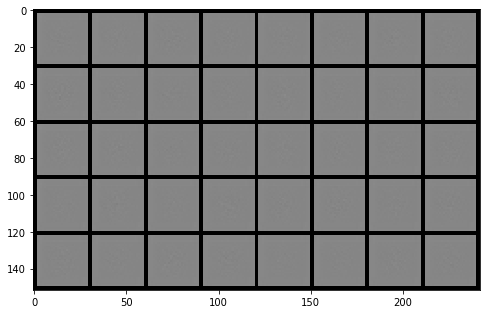

In [6]:
N = 40
imgs = xhat[:N].unsqueeze(0).unsqueeze(0).view(N, 1, 28, 28)
grid = make_grid(imgs).detach().cpu()
show(grid, figsize=(8,8))

**Loss**: does anything change from the lab?

In [7]:
# hint: see lab

def loss_function(xhat, x, mu, logvar, kl_weight=1.0):
  BCE = nn.functional.binary_cross_entropy(
      xhat.view(xhat.size(0), -1), x.view(x.size(0), -1), reduction='none'
  ).sum(1).mean()
  KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), 1).mean()

  loss = BCE + kl_weight*KLD
  return loss, BCE.item(), KLD.item()

In [8]:
# Test loss_function()
loss, bce, kld = loss_function(xhat, x, mu, logvar, kl_weight=1.0)
print(loss.item())
print(bce)
print(kld)

576.3474731445312
576.34228515625
0.005176636390388012


**Train on MNIST**: does anything change from the lab?

**Your task:** Implement training logic, and *produce a plot of training loss and a plot of validation loss* (x-axis: epoch, y-axis: loss). Each plot should contain three lines: total loss, BCE, and KL-divergence.

In [9]:
device = torch.device("cuda:0")
zdim = 20        # use this
kl_weight = 1.0  # use this

In [10]:
from tqdm import tqdm_notebook

def train(epoch):
    model.train()
    train_loss, bce, kld = 0, 0, 0
    for i, (x, y) in tqdm_notebook(enumerate(train_loader), total=len(train_loader)):
        x = x.to(device)
        
        xhat, mu, logvar = model(x)
        loss, bce_, kld_ = loss_function(xhat, x, mu, logvar, kl_weight)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        bce += bce_
        kld += kld_

    train_loss = train_loss / len(train_loader)
    bce = bce / len(train_loader)
    kld = kld / len(train_loader)

    print('====> Epoch: {} Average loss: {:.4f} (bce {:.4f}, kld {:.4f})'.format(
        epoch, train_loss, bce, kld))
    return train_loss, bce, kld

def valid(epoch):
    cache = dict(mus=[], logvars=[], ys=[])
    mus, logvars, ys = [], [], []
    model.eval()
    test_loss, bce, kld = 0, 0, 0
    with torch.no_grad():
        for i, (x, y) in enumerate(test_loader):
            x = x.to(device)

            xhat, mu, logvar = model(x)
            loss, bce_, kld_ = loss_function(xhat, x, mu, logvar, kl_weight)
            
            test_loss += loss.item()
            bce += bce_
            kld += kld_

            cache['mus'].append(mu)
            cache['logvars'].append(logvar)
            cache['ys'].append(y)
    
    test_loss = test_loss / len(test_loader)
    bce = bce / len(test_loader)
    kld = kld / len(test_loader)

    print('====> Valid set loss: {:.4f} (bce {:.4f}, kld {:.4f})'.format(
        test_loss, bce, kld))
    return cache, test_loss, bce, kld

In [11]:
# model & optimizer
model = VAE(20).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [12]:
# train, validate ..
best_val_loss = np.inf
train_loss_list, train_bce_list, train_kld_list = [], [], []
val_loss_list, val_bce_list, val_kld_list = [], [], []
patience_counter = 0

for epoch in range(1, 50):
    train_loss, bce, kld = train(epoch)
    train_loss_list.append(train_loss)
    train_bce_list.append(bce)
    train_kld_list.append(kld)

    cache, val_loss, bce, kld = valid(epoch)
    val_loss_list.append(val_loss)
    val_bce_list.append(bce)
    val_kld_list.append(kld)

    if val_loss < best_val_loss:
        patience_counter = 0
        torch.save({
            'state_dict': model.state_dict(),
            'valid_loss': val_loss
        }, open('model.pt', 'wb'))
        best_val_loss = val_loss
    else:
        patience_counter += 1

    if patience_counter > 5:
        break

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



====> Epoch: 1 Average loss: 219.4724 (bce 217.0086, kld 2.4638)
====> Valid set loss: 195.6058 (bce 190.5516, kld 5.0542)



====> Epoch: 2 Average loss: 158.8744 (bce 149.8367, kld 9.0376)
====> Valid set loss: 144.2571 (bce 132.9077, kld 11.3494)



====> Epoch: 3 Average loss: 130.8533 (bce 117.4623, kld 13.3910)
====> Valid set loss: 128.7961 (bce 113.7670, kld 15.0291)



====> Epoch: 4 Average loss: 119.4797 (bce 103.5922, kld 15.8876)
====> Valid set loss: 121.7035 (bce 104.5341, kld 17.1694)



====> Epoch: 5 Average loss: 114.1455 (bce 97.2636, kld 16.8819)
====> Valid set loss: 119.3639 (bce 102.7270, kld 16.6369)



====> Epoch: 6 Average loss: 111.3135 (bce 94.0600, kld 17.2535)
====> Valid set loss: 116.9756 (bce 99.6228, kld 17.3528)



====> Epoch: 7 Average loss: 109.4948 (bce 91.9851, kld 17.5097)
====> Valid set loss: 115.0318 (bce 97.1070, kld 17.9249)



====> Epoch: 8 Average loss: 108.2241 (bce 90.5509, kld 17.6732)
====> Valid set loss: 111.6527 (bce 94.0581, kld 17.5945)



====> Epoch: 9 Average loss: 107.0785 (bce 89.2586, kld 17.8199)
====> Valid set loss: 111.9155 (bce 94.5515, kld 17.3640)



====> Epoch: 10 Average loss: 106.1926 (bce 88.2551, kld 17.9375)
====> Valid set loss: 111.0849 (bce 92.8474, kld 18.2375)



====> Epoch: 11 Average loss: 105.3176 (bce 87.2130, kld 18.1046)
====> Valid set loss: 110.2869 (bce 92.0571, kld 18.2298)



====> Epoch: 12 Average loss: 104.6036 (bce 86.2775, kld 18.3261)
====> Valid set loss: 107.1673 (bce 88.9927, kld 18.1747)



====> Epoch: 13 Average loss: 103.7108 (bce 85.1737, kld 18.5371)
====> Valid set loss: 107.4391 (bce 89.0033, kld 18.4359)



====> Epoch: 14 Average loss: 102.9478 (bce 84.2749, kld 18.6728)
====> Valid set loss: 106.4529 (bce 87.9795, kld 18.4734)



====> Epoch: 15 Average loss: 102.2144 (bce 83.3851, kld 18.8293)
====> Valid set loss: 104.6403 (bce 86.5796, kld 18.0607)



====> Epoch: 16 Average loss: 101.9480 (bce 83.0497, kld 18.8983)
====> Valid set loss: 103.9738 (bce 85.1693, kld 18.8045)



====> Epoch: 17 Average loss: 101.2864 (bce 82.3188, kld 18.9676)
====> Valid set loss: 103.2948 (bce 84.3311, kld 18.9638)



====> Epoch: 18 Average loss: 100.9129 (bce 81.8537, kld 19.0592)
====> Valid set loss: 105.0555 (bce 86.0112, kld 19.0443)



====> Epoch: 19 Average loss: 100.5177 (bce 81.4300, kld 19.0877)
====> Valid set loss: 102.5232 (bce 83.4590, kld 19.0642)



====> Epoch: 20 Average loss: 100.1106 (bce 80.9741, kld 19.1365)
====> Valid set loss: 103.3762 (bce 83.8196, kld 19.5565)



====> Epoch: 21 Average loss: 99.9427 (bce 80.7294, kld 19.2133)
====> Valid set loss: 102.7598 (bce 83.1551, kld 19.6047)



====> Epoch: 22 Average loss: 99.5564 (bce 80.2738, kld 19.2826)
====> Valid set loss: 102.3670 (bce 82.9125, kld 19.4546)



====> Epoch: 23 Average loss: 99.1462 (bce 79.8247, kld 19.3215)
====> Valid set loss: 100.9421 (bce 81.7828, kld 19.1593)



====> Epoch: 24 Average loss: 99.0206 (bce 79.6111, kld 19.4095)
====> Valid set loss: 101.3509 (bce 81.9895, kld 19.3614)



====> Epoch: 25 Average loss: 98.6427 (bce 79.1620, kld 19.4807)
====> Valid set loss: 100.2940 (bce 81.2586, kld 19.0354)



====> Epoch: 26 Average loss: 98.4913 (bce 78.9707, kld 19.5206)
====> Valid set loss: 99.3345 (bce 79.8359, kld 19.4985)



====> Epoch: 27 Average loss: 98.2372 (bce 78.6618, kld 19.5754)
====> Valid set loss: 97.9141 (bce 78.9735, kld 18.9407)



====> Epoch: 28 Average loss: 97.8846 (bce 78.2663, kld 19.6183)
====> Valid set loss: 99.7764 (bce 80.2817, kld 19.4948)



====> Epoch: 29 Average loss: 97.6590 (bce 77.9780, kld 19.6809)
====> Valid set loss: 98.9748 (bce 79.1645, kld 19.8104)



====> Epoch: 30 Average loss: 97.5134 (bce 77.7986, kld 19.7147)
====> Valid set loss: 98.9212 (bce 79.0429, kld 19.8783)



====> Epoch: 31 Average loss: 97.3340 (bce 77.6182, kld 19.7159)
====> Valid set loss: 98.0460 (bce 78.1351, kld 19.9109)



====> Epoch: 32 Average loss: 97.0881 (bce 77.3377, kld 19.7504)
====> Valid set loss: 96.6090 (bce 77.2470, kld 19.3620)



====> Epoch: 33 Average loss: 96.9619 (bce 77.1785, kld 19.7835)
====> Valid set loss: 98.4215 (bce 78.0832, kld 20.3383)



====> Epoch: 34 Average loss: 96.8280 (bce 77.0209, kld 19.8071)
====> Valid set loss: 98.2100 (bce 78.2893, kld 19.9207)



====> Epoch: 35 Average loss: 96.6628 (bce 76.8275, kld 19.8353)
====> Valid set loss: 97.7401 (bce 78.0403, kld 19.6998)



====> Epoch: 36 Average loss: 96.3745 (bce 76.5215, kld 19.8530)
====> Valid set loss: 97.7034 (bce 78.0063, kld 19.6971)



====> Epoch: 37 Average loss: 96.3577 (bce 76.5334, kld 19.8243)
====> Valid set loss: 97.1639 (bce 77.4740, kld 19.6899)



====> Epoch: 38 Average loss: 96.3174 (bce 76.4427, kld 19.8747)
====> Valid set loss: 96.2666 (bce 76.0531, kld 20.2134)



====> Epoch: 39 Average loss: 96.1014 (bce 76.1909, kld 19.9105)
====> Valid set loss: 97.3600 (bce 77.4347, kld 19.9253)



====> Epoch: 40 Average loss: 95.9955 (bce 76.0714, kld 19.9241)
====> Valid set loss: 95.6967 (bce 76.1817, kld 19.5151)



====> Epoch: 41 Average loss: 95.9640 (bce 76.0294, kld 19.9347)
====> Valid set loss: 96.5780 (bce 76.7141, kld 19.8639)



====> Epoch: 42 Average loss: 95.7423 (bce 75.7904, kld 19.9519)
====> Valid set loss: 95.4085 (bce 75.0930, kld 20.3155)



====> Epoch: 43 Average loss: 95.6664 (bce 75.6872, kld 19.9792)
====> Valid set loss: 95.2348 (bce 75.3870, kld 19.8478)



====> Epoch: 44 Average loss: 95.5672 (bce 75.5981, kld 19.9691)
====> Valid set loss: 95.9857 (bce 75.8733, kld 20.1124)



====> Epoch: 45 Average loss: 95.4912 (bce 75.4862, kld 20.0050)
====> Valid set loss: 95.5169 (bce 75.1530, kld 20.3639)



====> Epoch: 46 Average loss: 95.3452 (bce 75.3413, kld 20.0039)
====> Valid set loss: 94.7613 (bce 74.9198, kld 19.8415)



====> Epoch: 47 Average loss: 95.2502 (bce 75.2304, kld 20.0198)
====> Valid set loss: 94.5509 (bce 75.0154, kld 19.5354)



====> Epoch: 48 Average loss: 95.1502 (bce 75.1151, kld 20.0351)
====> Valid set loss: 94.8690 (bce 74.8084, kld 20.0606)



====> Epoch: 49 Average loss: 94.9886 (bce 74.9224, kld 20.0662)
====> Valid set loss: 94.9066 (bce 74.8237, kld 20.0829)


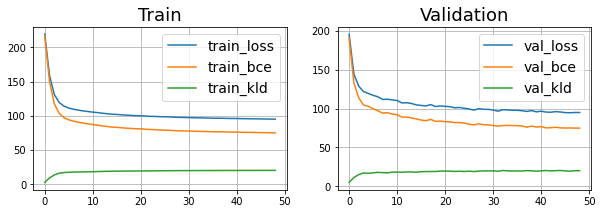

In [13]:
# produce plot ...
train_results = train_loss_list, train_bce_list, train_kld_list
val_results = val_loss_list, val_bce_list, val_kld_list
plot_learning_curve(train_results, val_results, title=None, figsize=(10,3))

In [14]:
model.load_state_dict(torch.load('model.pt')['state_dict'])
model = model.cuda()

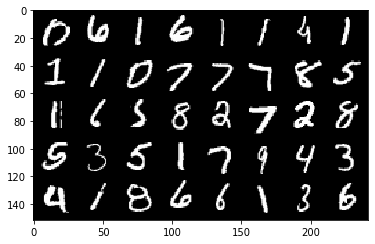

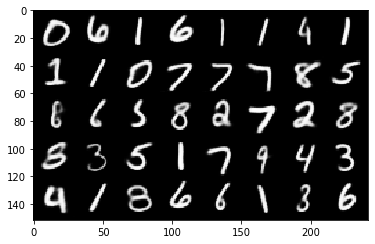

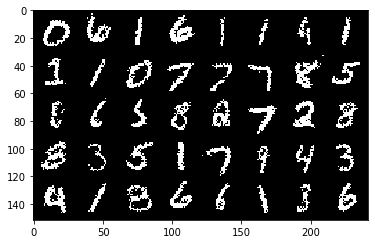

In [22]:
N = 40

# Input Images
imgs = x[:N].unsqueeze(0).unsqueeze(0).view(N, 1, 28, 28)
grid = make_grid(imgs).detach().cpu()
show(grid, figsize=(6,6))

# Reconstructed Images
xhat, mu, logvar = model(x.cuda())
imgs = xhat[:N].unsqueeze(0).unsqueeze(0).view(N, 1, 28, 28)
grid = make_grid(imgs).detach().cpu()
show(grid, figsize=(6,6))

# Sample from Bernoulli Images
x_bernoulli = torch.bernoulli(xhat)
imgs = x_bernoulli[:N].unsqueeze(0).unsqueeze(0).view(N, 1, 28, 28)
grid = make_grid(imgs).detach().cpu()
show(grid, figsize=(6,6))

### Evaluation
- **We provide the code below for sampling, interpolation, and marginal likelihood estimation**
- Sampling and interpolation: achieve similar to the lab (this is subjective, so the purpose is to check if something is *way off*)
- Marginal likelihood: achieve better than the lab



*Please ensure that `model` contains the model state that you will use for evaluation before running these.*

#### Sampling

*no code modification needed*

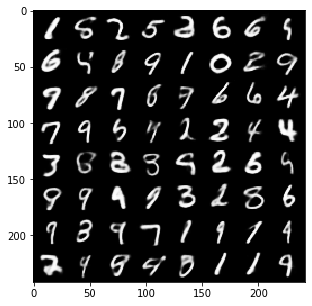

In [17]:
from torchvision.utils import make_grid

N = 64
model.cuda().eval()

# Sample z~p(z)
z = torch.randn((N, model.encoder.zdim)).to(device)

# Decode
sample = model.decoder(z)

# Visualize
imgs = sample
grid = make_grid(imgs).detach().cpu()
show(grid)

#### Interpolation

*no code modification needed*

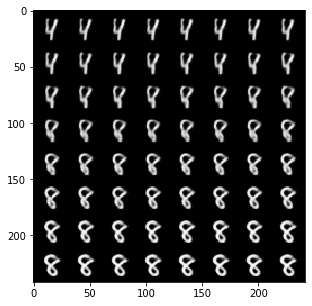

In [19]:
model.eval()

x, y = next(train_loader.__iter__())
xhat, mu, logvar = model(x.cuda())
si, ei = np.random.choice(batch_size, size=2, replace=False)
start = mu[si]
end = mu[ei]

N = 64

zs = torch.zeros(N, model.encoder.zdim).to(device)
for i in range(N):
    zs[i] = i / (N) * start.data + (1 - i / (N) ) * end.data
xhat = model.decoder(zs)

imgs = xhat.unsqueeze(0).unsqueeze(0).view(N, 1, 28, 28)
grid = make_grid(imgs).detach().cpu()
show(grid)

#### Marginal likelihood

*no code modification needed*

In [23]:
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)

eval_loader = torch.utils.data.DataLoader(
    MNIST('./data', train=False, transform=transforms.ToTensor()),
    batch_size=1, shuffle=True)

N_samples = 128

model.eval()
results = []
with torch.no_grad():
  for i, (x, y) in tqdm_notebook(enumerate(eval_loader), total=len(eval_loader)):
    x, y = next(eval_loader.__iter__())
    x = x.to(device).expand(N_samples, 1, 28, 28)

    # Obtain mu, logvar and sample z
    _, mu, logvar = model(x)
    z = mu + logvar.mul(0.5).exp()*torch.randn_like(mu)

    # Obtain xhat given the sampled z
    xhat = model.decoder(z)

    # Make a standard normal for p(z) and a normal for q(z|x)
    norm = MultivariateNormal(
        torch.zeros_like(mu[0]), 
        covariance_matrix=torch.diag(torch.ones_like(logvar[0]))
    )
    mvn = MultivariateNormal(
        mu[0], 
        covariance_matrix=torch.diag(logvar.exp()[0])
    )

    # Measure the (log) probabilities needed for the formula above
    log_pz = norm.log_prob(z)
    log_qzx = mvn.log_prob(z)
    x = x.view(xhat.size())
    log_pxz = -nn.functional.binary_cross_entropy(
        xhat, x, reduction='none'
    ).view(N_samples, -1).sum(1)

    # Compute the lowerbound (in log space)
    argsum = log_pxz + log_pz - log_qzx
    logpx = -np.log(N_samples) + torch.logsumexp(argsum, 0)
    results.append(logpx.item())

np.mean(results)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  del sys.path[0]


-92.34944872665405



---

# 2. Conditional variational autoencoder (20 points)

### A. Model

The conditional VAE involves:
- $q_{\phi}(\mathbf{z}|\mathbf{x},c)$: "encoder"
- $p_{\theta}(\mathbf{x}|\mathbf{z},c)$: "decoder"
- $p(\mathbf{z})$: prior

In our case, $c\in \{0,...,9\}$ is a discrete variable (class label).

**Your task:** Implement a `CVAE` that has an `encoder`, `decoder`, and `reparameterization`.

*Hints*: 
  1. Represent $c$ using a `nn.Embedding` layer, and concatenate it to the representation of $\mathbf{x}$.
    - e.g. $\mu = \texttt{linear([conv(x); emb(c)])}$
  2. Represent `decoder` inputs $\mathbf{z},c$ similarly, as $[\mathbf{z};\text{emb}(c)]$.
    - $\hat{x}=\texttt{deconv(linear([z; emb(c)]))}$

Otherwise, everything else is the same as VAE (plus passing $c$ as an argument in the right places). You can use the same convolutional layers as above.

In [24]:
class Encoder(nn.Module):
  def __init__(self, zdim, nclasses):
    super().__init__()
    # TODO
    hdim_1 = 16
    hdim_2 = 32
    hdim_3 = 64
    k1 = 7
    k2 = 5
    k3 = 3
    output_dim = ((28-k1+1)//2-k2-k3+2)**2*hdim_3

    cdim = 20
    output_dim += cdim
    
    self.c_embedding = nn.Embedding(nclasses, cdim)

    self.conv_layers = nn.Sequential(
        nn.Conv2d(1, hdim_1, k1),
        nn.ReLU(),
        nn.MaxPool2d(2),
        nn.Conv2d(hdim_1, hdim_2, k2),
        nn.ReLU(),
        nn.Conv2d(hdim_2, hdim_3, k3),
        nn.ReLU(),
    )

    self.mu = nn.Sequential(
        nn.Linear(output_dim, output_dim),
        nn.ReLU(),
        nn.Linear(output_dim, zdim)
    )
    self.logvar = nn.Sequential(
        nn.Linear(output_dim, output_dim),
        nn.ReLU(),
        nn.Linear(output_dim, zdim)
    )
    
    self.output_dim = output_dim
    self.zdim = zdim

  def forward(self, x, c):
    # TODO
    h = self.conv_layers(x)
    h_flat = torch.flatten(h, 1, -1)
    c_emb = self.c_embedding(c)
    mu = self.mu(torch.cat([h_flat, c_emb], dim=1))
    logvar = self.logvar(torch.cat([h_flat, c_emb], dim=1))
    return mu, logvar #h, h_flat, c_emb


class Decoder(nn.Module):
  def __init__(self, zdim, nclasses):
    super().__init__()

    cdim = 20
    self.c_embedding = nn.Embedding(nclasses, cdim)

    self.linear_expand = nn.Sequential(
        nn.Linear(zdim+cdim, 64*5*5),
        nn.ReLU(),
        nn.Linear(64*5*5, 64*5*5)
    )

    self.deconv_layers = nn.Sequential(
        nn.ConvTranspose2d(64, 32, 7),
        nn.ReLU(),
        nn.ConvTranspose2d(32, 16, 7),
        nn.ReLU(),
        nn.ConvTranspose2d(16, 8, 7),
        nn.ReLU(),
        nn.ConvTranspose2d(8, 1, 6),
        nn.Sigmoid()
    )

    self.zdim = zdim
  
  def forward(self, z, c):
    c_emb = self.c_embedding(c)
    h = self.linear_expand(torch.cat([z, c_emb], dim=1))
    h_reshaped = h.reshape(-1, 64, 5, 5)
    x_hat = self.deconv_layers(h_reshaped)
    return x_hat


class CVAE(nn.Module):
  def __init__(self, zdim=20, nclasses=10):
    super().__init__()
    self.encoder = Encoder(zdim, nclasses)
    self.decoder = Decoder(zdim, nclasses)

  def reparameterize(self, mu, logvar):
    if self.training:
      std = torch.exp(0.5*logvar)
      eps = torch.randn_like(std)
      z = mu + std*eps
    else:
      z = mu
    return z

  def forward(self, x, c):
    mu, logvar = self.encoder(x, c)
    z = self.reparameterize(mu, logvar)
    xhat = self.decoder(z, c)
    return xhat, mu, logvar

Test

In [25]:
model = CVAE(20, 10)
x,y = next(iter(train_loader))
xhat, mu, logvar = model(x.cpu(), y.cpu())
print(xhat.size())

torch.Size([256, 1, 28, 28])


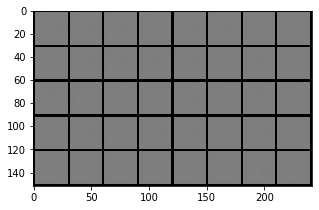

In [29]:
N = 40
imgs = xhat[:N].unsqueeze(0).unsqueeze(0).view(N, 1, 28, 28)
grid = make_grid(imgs).detach().cpu()
show(grid, figsize=(5,5))

**Loss:** same as VAE.

In [30]:
def loss_function(xhat, x, mu, logvar, kl_weight=1.0):
  BCE = nn.functional.binary_cross_entropy(
      xhat.view(xhat.size(0), -1), x.view(x.size(0), -1), reduction='none'
  ).sum(1).mean()
  KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), 1).mean()

  loss = BCE + kl_weight*KLD
  return loss, BCE.item(), KLD.item()

### C. Training

Train your conditional VAE model using your loss function on MNIST.

**Your task:** Implement training logic, and *produce a plot of training loss and a plot of validation loss* (x-axis: epoch, y-axis: loss). Each plot should contain three lines: total loss, BCE, and KL-divergence.


In [31]:
from tqdm import tqdm_notebook

def train_CVAE(epoch):
    model.train()
    train_loss, bce, kld = 0, 0, 0
    for i, (x, y) in tqdm_notebook(enumerate(train_loader), total=len(train_loader)):
        x = x.to(device)
        y = y.to(device)
        
        xhat, mu, logvar = model(x, y)
        loss, bce_, kld_ = loss_function(xhat, x, mu, logvar, kl_weight)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        bce += bce_
        kld += kld_

    train_loss = train_loss / len(train_loader)
    bce = bce / len(train_loader)
    kld = kld / len(train_loader)

    print('====> Epoch: {} Average loss: {:.4f} (bce {:.4f}, kld {:.4f})'.format(
        epoch, train_loss, bce, kld))
    return train_loss, bce, kld

def valid_CVAE(epoch):
    cache = dict(mus=[], logvars=[], ys=[])
    mus, logvars, ys = [], [], []
    model.eval()
    test_loss, bce, kld = 0, 0, 0
    with torch.no_grad():
        for i, (x, y) in enumerate(test_loader):
            x = x.to(device)
            y = y.to(device)

            xhat, mu, logvar = model(x, y)
            loss, bce_, kld_ = loss_function(xhat, x, mu, logvar, kl_weight)
            
            test_loss += loss.item()
            bce += bce_
            kld += kld_

            cache['mus'].append(mu)
            cache['logvars'].append(logvar)
            cache['ys'].append(y)
    
    test_loss = test_loss / len(test_loader)
    bce = bce / len(test_loader)
    kld = kld / len(test_loader)

    print('====> Valid set loss: {:.4f} (bce {:.4f}, kld {:.4f})'.format(
        test_loss, bce, kld))
    return cache, test_loss, bce, kld

In [32]:
device = torch.device("cuda:0")
zdim = 20        # use this
kl_weight = 1.0  # use this

# model & optimizer
model = CVAE(20, 10).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [33]:
# train, validate ..
best_val_loss = np.inf
train_loss_list, train_bce_list, train_kld_list = [], [], []
val_loss_list, val_bce_list, val_kld_list = [], [], []
patience_counter = 0

for epoch in range(1, 50):
    train_loss, bce, kld = train_CVAE(epoch)
    train_loss_list.append(train_loss)
    train_bce_list.append(bce)
    train_kld_list.append(kld)

    cache, val_loss, bce, kld = valid_CVAE(epoch)
    val_loss_list.append(val_loss)
    val_bce_list.append(bce)
    val_kld_list.append(kld)

    if val_loss < best_val_loss:
        patience_counter = 0
        torch.save({
            'state_dict': model.state_dict(),
            'valid_loss': val_loss
        }, open('model.pt', 'wb'))
        best_val_loss = val_loss
    else:
        patience_counter += 1

    if patience_counter > 5:
        break

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



====> Epoch: 1 Average loss: 184.4230 (bce 179.9795, kld 4.4435)
====> Valid set loss: 135.6099 (bce 127.0975, kld 8.5124)



====> Epoch: 2 Average loss: 127.2370 (bce 115.8054, kld 11.4316)
====> Valid set loss: 111.1074 (bce 97.3331, kld 13.7743)



====> Epoch: 3 Average loss: 112.8930 (bce 98.9483, kld 13.9447)
====> Valid set loss: 103.2769 (bce 88.3369, kld 14.9399)



====> Epoch: 4 Average loss: 107.0231 (bce 92.1691, kld 14.8539)
====> Valid set loss: 98.7453 (bce 83.4875, kld 15.2579)



====> Epoch: 5 Average loss: 103.5585 (bce 88.1561, kld 15.4024)
====> Valid set loss: 97.0269 (bce 81.1699, kld 15.8570)



====> Epoch: 6 Average loss: 101.2115 (bce 85.3344, kld 15.8771)
====> Valid set loss: 93.6285 (bce 77.6585, kld 15.9700)



====> Epoch: 7 Average loss: 99.5996 (bce 83.3244, kld 16.2752)
====> Valid set loss: 94.1649 (bce 77.5709, kld 16.5940)



====> Epoch: 8 Average loss: 98.3280 (bce 81.8262, kld 16.5018)
====> Valid set loss: 92.2524 (bce 75.6989, kld 16.5535)



====> Epoch: 9 Average loss: 97.1935 (bce 80.5190, kld 16.6745)
====> Valid set loss: 90.8338 (bce 74.6540, kld 16.1799)



====> Epoch: 10 Average loss: 96.5092 (bce 79.7144, kld 16.7947)
====> Valid set loss: 91.1903 (bce 74.4035, kld 16.7867)



====> Epoch: 11 Average loss: 96.0045 (bce 79.1002, kld 16.9043)
====> Valid set loss: 89.9001 (bce 72.8958, kld 17.0043)



====> Epoch: 12 Average loss: 95.1613 (bce 78.1726, kld 16.9887)
====> Valid set loss: 89.2371 (bce 72.6565, kld 16.5807)



====> Epoch: 13 Average loss: 94.7931 (bce 77.6685, kld 17.1246)
====> Valid set loss: 88.9882 (bce 71.7638, kld 17.2244)



====> Epoch: 14 Average loss: 94.2747 (bce 77.0870, kld 17.1877)
====> Valid set loss: 88.9379 (bce 71.7340, kld 17.2039)



====> Epoch: 15 Average loss: 94.1027 (bce 76.8265, kld 17.2763)
====> Valid set loss: 88.5655 (bce 71.1222, kld 17.4433)



====> Epoch: 16 Average loss: 93.4006 (bce 76.0476, kld 17.3530)
====> Valid set loss: 87.6964 (bce 70.8085, kld 16.8879)



====> Epoch: 17 Average loss: 93.2120 (bce 75.7844, kld 17.4276)
====> Valid set loss: 87.2321 (bce 70.3020, kld 16.9301)



====> Epoch: 18 Average loss: 92.8926 (bce 75.4370, kld 17.4555)
====> Valid set loss: 87.2993 (bce 69.7452, kld 17.5541)



====> Epoch: 19 Average loss: 92.6137 (bce 75.1044, kld 17.5093)
====> Valid set loss: 88.0131 (bce 70.0885, kld 17.9246)



====> Epoch: 20 Average loss: 92.3635 (bce 74.7861, kld 17.5774)
====> Valid set loss: 87.4722 (bce 70.0186, kld 17.4537)



====> Epoch: 21 Average loss: 92.0472 (bce 74.4181, kld 17.6291)
====> Valid set loss: 87.3418 (bce 69.5950, kld 17.7468)



====> Epoch: 22 Average loss: 91.9464 (bce 74.3258, kld 17.6206)
====> Valid set loss: 87.3744 (bce 69.4697, kld 17.9047)



====> Epoch: 23 Average loss: 91.7621 (bce 74.1007, kld 17.6614)
====> Valid set loss: 86.5906 (bce 68.9008, kld 17.6898)



====> Epoch: 24 Average loss: 91.3674 (bce 73.6780, kld 17.6893)
====> Valid set loss: 86.1544 (bce 68.8540, kld 17.3004)



====> Epoch: 25 Average loss: 91.3220 (bce 73.5851, kld 17.7369)
====> Valid set loss: 86.2653 (bce 68.4860, kld 17.7793)



====> Epoch: 26 Average loss: 91.0934 (bce 73.3490, kld 17.7444)
====> Valid set loss: 86.5255 (bce 68.9950, kld 17.5305)



====> Epoch: 27 Average loss: 91.0161 (bce 73.2547, kld 17.7614)
====> Valid set loss: 86.3040 (bce 68.5479, kld 17.7560)



====> Epoch: 28 Average loss: 90.7997 (bce 73.0043, kld 17.7955)
====> Valid set loss: 85.9696 (bce 68.1161, kld 17.8535)



====> Epoch: 29 Average loss: 90.5869 (bce 72.7767, kld 17.8103)
====> Valid set loss: 85.8796 (bce 68.1422, kld 17.7374)



====> Epoch: 30 Average loss: 90.5428 (bce 72.7138, kld 17.8289)
====> Valid set loss: 86.0869 (bce 68.1739, kld 17.9130)



====> Epoch: 31 Average loss: 90.4354 (bce 72.6277, kld 17.8077)
====> Valid set loss: 85.8346 (bce 68.2037, kld 17.6309)



====> Epoch: 32 Average loss: 90.2097 (bce 72.3717, kld 17.8380)
====> Valid set loss: 86.3031 (bce 68.4336, kld 17.8695)



====> Epoch: 33 Average loss: 90.1556 (bce 72.2724, kld 17.8832)
====> Valid set loss: 84.9236 (bce 67.5063, kld 17.4173)



====> Epoch: 34 Average loss: 89.9249 (bce 72.0473, kld 17.8776)
====> Valid set loss: 86.2099 (bce 68.3332, kld 17.8767)



====> Epoch: 35 Average loss: 89.9744 (bce 72.0644, kld 17.9100)
====> Valid set loss: 85.4471 (bce 67.5662, kld 17.8809)



====> Epoch: 36 Average loss: 89.7269 (bce 71.8227, kld 17.9041)
====> Valid set loss: 85.5156 (bce 67.2366, kld 18.2790)



====> Epoch: 37 Average loss: 89.6549 (bce 71.7321, kld 17.9228)
====> Valid set loss: 85.2184 (bce 67.1896, kld 18.0288)



====> Epoch: 38 Average loss: 89.5008 (bce 71.5223, kld 17.9785)
====> Valid set loss: 85.2530 (bce 67.4369, kld 17.8161)



====> Epoch: 39 Average loss: 89.4468 (bce 71.4846, kld 17.9622)
====> Valid set loss: 85.4523 (bce 67.4747, kld 17.9776)


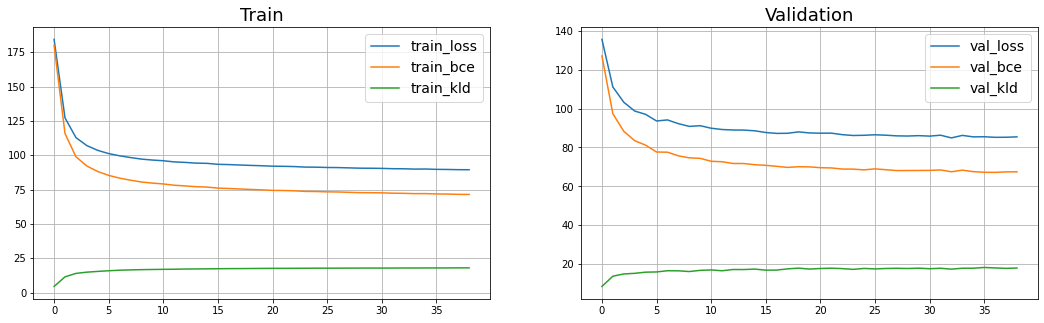

In [44]:
# produce plot ...
train_results = train_loss_list, train_bce_list, train_kld_list
val_results = val_loss_list, val_bce_list, val_kld_list
plot_learning_curve(train_results, val_results, title=None, figsize=(18,5))

In [35]:
model.load_state_dict(torch.load('model.pt')['state_dict'])
model = model.cuda()

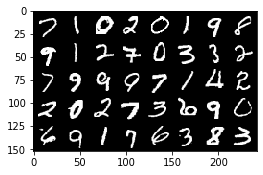

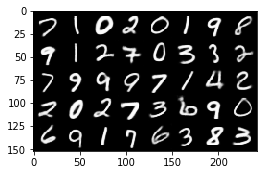

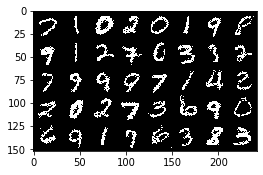

In [36]:
N = 40

# Input Images
imgs = x[:N].unsqueeze(0).unsqueeze(0).view(N, 1, 28, 28)
grid = make_grid(imgs).detach().cpu()
show(grid, figsize=(4,4))

# Reconstructed Images
xhat, mu, logvar = model(x.cuda(), y.cuda())
imgs = xhat[:N].unsqueeze(0).unsqueeze(0).view(N, 1, 28, 28)
grid = make_grid(imgs).detach().cpu()
show(grid, figsize=(4,4))

# Sample from Bernoulli Images
x_bernoulli = torch.bernoulli(xhat)
imgs = x_bernoulli[:N].unsqueeze(0).unsqueeze(0).view(N, 1, 28, 28)
grid = make_grid(imgs).detach().cpu()
show(grid, figsize=(4,4))

### D. Conditional generation

**Your task**: complete the code below to produce a grid of samples with 10 rows, where the $i$'th row has samples of class $i$.

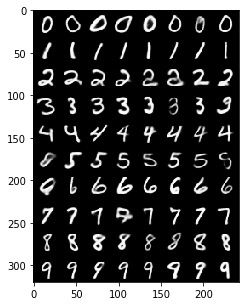

In [40]:
N = 8
model.eval()
grids = []
for y_ in range(10):
  
  # TODO (the ... does not imply it is a single line)
  z = torch.randn((N, model.encoder.zdim)).to(device)
  c = (torch.ones(N)*y_).long().to(device)
  sample = model.decoder(z, c)

  grid = make_grid(sample).detach().cpu()
  grids.append(grid)

grid = torch.cat(grids, 1)
show(grid);